# 1. Install Dependencies and Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tqdm.keras import TqdmCallback

import os

2024-09-15 18:27:41.642426: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-15 18:27:41.875203: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-15 18:27:42.738635: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64
2024-09-15 18:27:42.738745: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: can

In [2]:
# Disable GPU and use CPU only
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

print("GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

GPUs Available:  0


2024-09-15 18:27:44.098437: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-09-15 18:27:44.098480: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: el-VivoBook-15-ASUS-Laptop-X507UBR
2024-09-15 18:27:44.098494: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: el-VivoBook-15-ASUS-Laptop-X507UBR
2024-09-15 18:27:44.098625: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 560.35.3
2024-09-15 18:27:44.098661: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 560.35.3
2024-09-15 18:27:44.098669: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 560.35.3


In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [5]:
import cv2
import imghdr

In [6]:
data_dir = '/home/el/Documents/workspace/Image_classifier/sc-islet_classifier/images/' 

In [7]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [8]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [9]:
# Load dataset
data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(256, 256),  # Resize images to 256x256
    batch_size=32,  # Adjust the batch size if needed
    label_mode='int',  # Binary classification, 0 or 1 for class labels
    shuffle=True,  # Shuffle the dataset
    validation_split=0.2,  # Reserve 20% for validation
    subset='training',  # Load the training subset
    seed=123  # Set a seed for reproducibility
)

# Load the validation data
val_data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(256, 256),
    batch_size=32,
    label_mode='int',
    shuffle=True,
    validation_split=0.2,  # Same split
    subset='validation',  # Load the validation subset
    seed=123
)

# Check the class names
print(f"Class names: {data.class_names}")

Found 225 files belonging to 2 classes.
Using 180 files for training.
Found 225 files belonging to 2 classes.
Using 45 files for validation.
Class names: ['Functional', 'Non-Functional']


2024-09-15 18:27:49.770121: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
data_iterator = data.as_numpy_iterator()

In [11]:
batch = data_iterator.next()

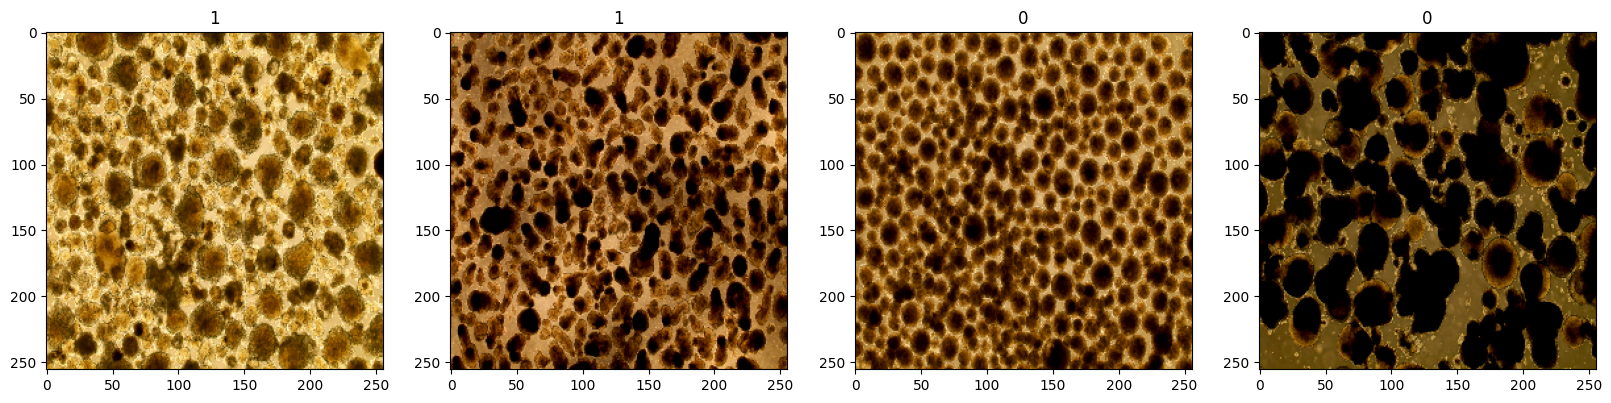

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [13]:
data = data.map(lambda x,y: (x/255, y))

In [14]:
data.as_numpy_iterator().next()

(array([[[[7.90196061e-01, 5.30392170e-01, 3.05882365e-01],
          [5.35294116e-01, 2.92156875e-01, 7.74509832e-02],
          [7.62745082e-01, 4.78431374e-01, 2.06862748e-01],
          ...,
          [5.11764705e-01, 2.43137255e-01, 1.17647061e-02],
          [5.03921568e-01, 2.47058824e-01, 9.80392215e-04],
          [5.34313738e-01, 2.63725489e-01, 4.70588244e-02]],
 
         [[6.40196085e-01, 4.51960772e-01, 2.65686274e-01],
          [4.49019611e-01, 1.55882359e-01, 0.00000000e+00],
          [6.16666675e-01, 3.23529422e-01, 9.31372568e-02],
          ...,
          [5.06862760e-01, 2.34313726e-01, 4.90196096e-03],
          [5.28431356e-01, 2.55882353e-01, 2.25490201e-02],
          [5.17647088e-01, 2.52941191e-01, 2.05882359e-02]],
 
         [[6.51960790e-01, 3.95098031e-01, 1.89215690e-01],
          [5.10784328e-01, 2.61764705e-01, 2.25490201e-02],
          [6.45098031e-01, 3.55882347e-01, 1.34313732e-01],
          ...,
          [5.75490177e-01, 2.99019605e-01, 6.9607

# 5. Split Data

In [15]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [16]:
train_size

4

In [17]:
# Function to resize images to 128x128
def resize_images(image, label):
    image = tf.image.resize(image, [256, 256])  # Resize image to 256x256
    return image, label

In [18]:
# Split the dataset and apply resizing
train = data.take(train_size).map(resize_images)
val = data.skip(train_size).take(val_size).map(resize_images)
test = data.skip(train_size + val_size).take(test_size).map(resize_images)

# 6. Build Deep Learning Model

In [41]:
train

<MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [20]:
def mlp(x, hidden_units, dropout_rate):
    """ Multilayer Perceptron (MLP) for the transformer block """
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

def create_vit_classifier(image_size=256, patch_size=16, num_patches=256 // 16, projection_dim=64, num_heads=4, transformer_units=[128, 64], num_transformer_layers=8, mlp_head_units=[128], num_classes=1):
    """ Create the Vision Transformer (ViT) model """
    inputs = layers.Input(shape=(image_size, image_size, 3))

    # Extract patches from the input image
    patches = layers.Conv2D(filters=projection_dim, kernel_size=patch_size, strides=patch_size, padding="valid")(inputs)

    # Flatten patches
    flattened_patches = layers.Reshape((num_patches * num_patches, projection_dim))(patches)

    # Positional encoding for patch sequence
    positions = tf.range(start=0, limit=num_patches * num_patches, delta=1)
    positional_embedding = layers.Embedding(input_dim=num_patches * num_patches, output_dim=projection_dim)(positions)

    # Add the positional embeddings to the patches
    encoded_patches = flattened_patches + positional_embedding

    # Transformer blocks
    for _ in range(num_transformer_layers):
        # Layer normalization
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

        # Multi-head attention
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
        attention_output = layers.Dropout(0.1)(attention_output)

        # Skip connection
        encoded_patches = layers.Add()([attention_output, encoded_patches])

        # Layer normalization
        x2 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

        # MLP
        x2 = mlp(x2, hidden_units=transformer_units, dropout_rate=0.1)

        # Skip connection
        encoded_patches = layers.Add()([x2, encoded_patches])

    # Global average pooling
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.GlobalAveragePooling1D()(representation)

    # Fully connected layer
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)

    # Output layer for binary classification
    logits = layers.Dense(num_classes, activation="sigmoid")(features)

    # Create the Keras model
    model = models.Model(inputs=inputs, outputs=logits)
    return model


# 7. Train

In [21]:
logdir='logs'

In [22]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [31]:
# Create the Vision Transformer (ViT) model
# Increase the number of transformer layers and attention heads
vit_model = create_vit_classifier(
    image_size=256, 
    patch_size=16, 
    projection_dim=128,  # Increase projection dimension
    num_heads=8,         # Increase the number of attention heads
    transformer_units=[256, 128],  # Increase units in the MLP for transformer
    num_transformer_layers=10,  # Increase transformer layers
    mlp_head_units=[256, 128]   # Increase units in the final MLP head
)


# Compile the model
vit_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

# Check the model architecture
vit_model.summary()

# Train the model with training and validation data
hist = vit_model.fit(
    data,
    validation_data=val_data,
    epochs=50,  
    callbacks=[
        TqdmCallback(verbose=1),  # This adds the tqdm progress bar
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3)
    ]
)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 16, 16, 128)  98432       ['input_3[0][0]']                
                                                                                                  
 reshape_2 (Reshape)            (None, 256, 128)     0           ['conv2d_2[0][0]']               
                                                                                                  
 tf.__operators__.add_2 (TFOpLa  (None, 256, 128)    0           ['reshape_2[0][0]']        

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/50
6/6 [==============================] - 101s 14s/step - loss: 0.8272 - accuracy: 0.5667 - val_loss: 0.6750 - val_accuracy: 0.6889 - lr: 0.0010
Epoch 2/50
6/6 [==============================] - 86s 14s/step - loss: 0.7549 - accuracy: 0.5667 - val_loss: 0.6259 - val_accuracy: 0.6889 - lr: 0.0010
Epoch 3/50
6/6 [==============================] - 84s 14s/step - loss: 0.8290 - accuracy: 0.4056 - val_loss: 0.6240 - val_accuracy: 0.6889 - lr: 0.0010
Epoch 4/50
6/6 [==============================] - 84s 14s/step - loss: 0.7155 - accuracy: 0.5444 - val_loss: 0.6208 - val_accuracy: 0.6889 - lr: 0.0010
Epoch 5/50
6/6 [==============================] - 85s 14s/step - loss: 0.7442 - accuracy: 0.4722 - val_loss: 0.6213 - val_accuracy: 0.6889 - lr: 0.0010
Epoch 6/50
6/6 [==============================] - 84s 14s/step - loss: 0.7099 - accuracy: 0.5167 - val_loss: 0.6231 - val_accuracy: 0.6889 - lr: 0.0010
Epoch 7/50
6/6 [==============================] - 85s 14s/step - loss: 0.6782 - accurac

# 8. Plot Performance

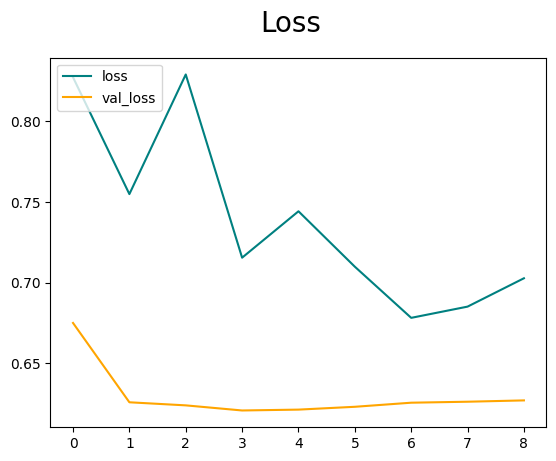

In [32]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

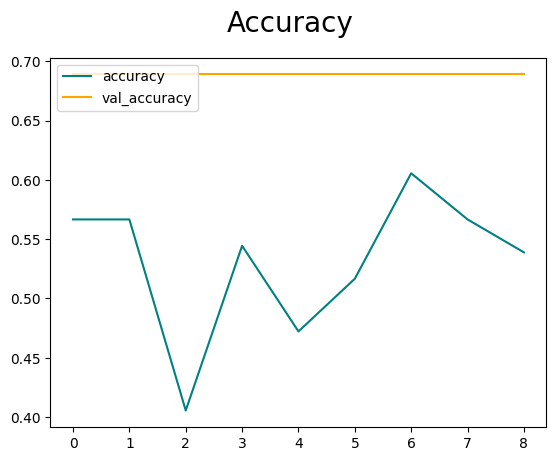

In [33]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Test

In [42]:
import cv2

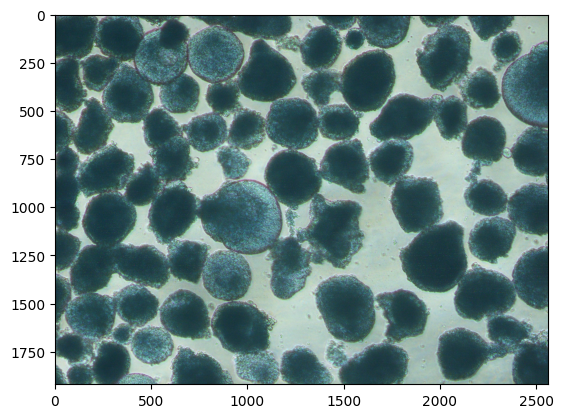

In [43]:
img = cv2.imread('/home/el/Documents/workspace/Image_classifier/sc-islet_classifier/BC007-1-D33.jpg')
plt.imshow(img)
plt.show()

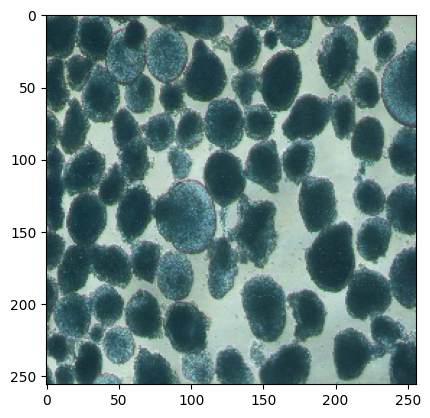

In [44]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [45]:
yhat = vit_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 2s 2s/step


In [46]:
yhat

array([[0.61800075]], dtype=float32)

In [47]:
if yhat > 0.5: 
    print(f'Predicted class is Non-fuctional')
else:
    print(f'Predicted class is Functional')

Predicted class is Non-fuctional


# 10. Save the Model

In [51]:
from tensorflow.keras.models import load_model

In [49]:
vit_model.save(os.path.join('models','VIT_imageclassifier.h5'))

In [50]:
!pip list

Package                      Version
---------------------------- --------------
absl-py                      2.1.0
altair                       5.4.1
anyio                        4.4.0
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.3.0
asttokens                    2.4.1
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        24.2.0
babel                        2.16.0
beautifulsoup4               4.12.3
bleach                       6.1.0
blinker                      1.8.2
cachetools                   5.5.0
certifi                      2024.8.30
cffi                         1.17.1
charset-normalizer           3.3.2
click                        8.1.7
comm                         0.2.2
contourpy                    1.3.0
cycler                       0.12.1
debugpy                      1.8.5
decorator                    5.1.1
defusedxml                   0.7.1
exceptiongroup               1.2.